In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import re

import metpy.calc as mpcalc
from metpy.units import units
# local module
import mypaths

In [2]:
date = pd.datetime(2018, 3, 2)

In [3]:
time_range = (pd.date_range(start=date,
                            freq='T',
                            end=date+timedelta(hours=23, minutes=59, seconds=59))
              .to_series()
              .to_frame(name='time'))

In [4]:
inputdir = mypaths.wpk_dir / '2_Leg' / 'TRUEWIND'

In [5]:
fname = inputdir / f'Wpk_st02@{date:%Y_%m_%d}.txt'
print(fname.exists())
# fname = inputdir / f'data_3_{date:%Y%m%d_%H}.log'

True


In [6]:
def wpk_latlon_parser(s):
    latlon_re = re.compile(r'''
# Latitude part
(?P<lat_hem>[NS])\s*
(?P<lat_deg>[0-9]{2})\s*
(?P<lat_min>[0-9]{1,2}\.[0-9]{3})\s*

# Longitude part
(?P<lon_hem>[EW])\s*
(?P<lon_deg>[0-9]{3})\s*
(?P<lon_min>[0-9]{1,2}\.[0-9]{3})''', re.X)
    
    m = re.match(latlon_re, s)
    if m.group('lat_hem') == 'S':
        lat_factor = -1
    else:
        lat_factor = 1
        
    if m.group('lon_hem') == 'W':
        lon_factor = -1
    else:
        lon_factor = 1
        
    lat = lat_factor * (float(m.group('lat_deg')) + float(m.group('lat_min')) / 60)
    lon = lon_factor * (float(m.group('lon_deg')) + float(m.group('lon_min')) / 60)
    
    return lat, lon

In [7]:
df = pd.read_csv(fname, parse_dates=[[1, 2]], index_col=0,
                 date_parser=lambda x: datetime.strptime(x, '%y/%m/%d %H:%M:%S'))
# df.index.rename('DateTime', inplace=True)
df[['latitude', 'longitude']] = (df['Ship position']
                                 .map(wpk_latlon_parser, na_action='ignore')
                                 .apply(pd.Series)
                                 .rename(mapper={0: 'latitude', 1: 'longitude'}, axis=1))
df = df.drop(labels=['Unit ID', 'Ship position'], axis=1)

In [8]:
# df0 = pd.merge(time_range, df,
#                how='left', left_index=True, right_index=True)
# df0.shape

In [9]:
labels = time_range.index
df0 = pd.concat([df, time_range]).sort_index().interpolate(method='values', limit_direction='both').drop('time', axis=1)
df0.index = df0.index.rename('time')
df0 = df0.loc[df0.index.intersection(labels)]
df0 = df0[~df0.index.duplicated(keep='first')]

In [10]:
df0.head()

,Air T (C),BIT,Barometric pressure (mbar),CMG,Gyro,RH (%),Rel. wind dir (ref. to ship bow),Rel. wind speed (m/s),Ship velocity m/s,Sigma theta,Solar (W/m^2),True W Dir (Referred to N),True wind sp (m/s),VBAT (Vdc),Wind gust (m/s),latitude,longitude
time,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-3.6,1000.0,801.90,159.0,153.60,64.0,244.0,6.30,4.00,6.80,0.0,15.40,9.10,15.8,7.40,69.840200,-16.947383
2018-03-02 00:01:00,-3.6,1000.0,801.95,159.5,153.65,64.5,244.0,7.15,4.00,4.95,0.0,17.40,9.90,15.8,8.20,69.839217,-16.946133
2018-03-02 00:02:00,-3.6,1000.0,802.10,158.5,153.65,64.0,240.0,7.60,4.00,4.10,0.0,15.40,10.40,15.8,8.55,69.837258,-16.943642
2018-03-02 00:03:00,-3.6,1000.0,802.25,156.0,153.10,63.0,235.0,7.00,4.05,6.10,0.0,9.55,10.00,15.8,8.00,69.835292,-16.941125
2018-03-02 00:04:00,-3.6,1000.0,802.20,154.5,153.00,63.0,239.5,7.25,4.00,5.15,0.0,12.75,9.95,15.8,8.55,69.833300,-16.938617


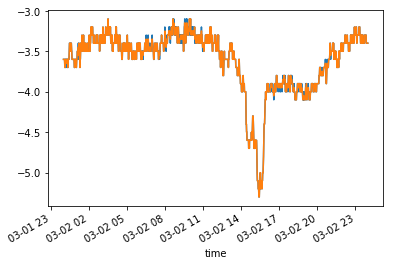

In [11]:
df['Air T (C)'].plot()
df0['Air T (C)'].plot()

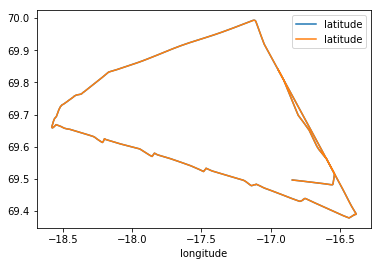

In [12]:
fig, ax = plt.subplots()
df.plot(ax=ax, x='longitude', y='latitude')
df0.plot(ax=ax, x='longitude', y='latitude')